In [46]:
from os import path
import pandas as pd
from corputil import ListCorpus
from corputil.utils import load_stopwords
from gensim.models import LdaMulticore
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary

stopwords = load_stopwords(path.join('data', 'german.txt'))

In [47]:
num_topics = 100
chunksize, iterations, passes = 2000, 500, 20
labels = ['2015KW44', '2015KW45', '2015KW46', '2015KW47', '2015KW48', '2015KW49', '2015KW50', '2015KW51']
files = [path.join('data', 'CurrentNews', 'RAW_{}.csv').format(label) for label in labels[:4]]
output_model = [path.join('models', 'lda', '{}.lda').format(label) for label in labels]
output_dict = path.join('models', 'lda', 'Words.dict')
output_bigram = path.join('models', 'lda', 'Bigram.phrase')

In [48]:
dfs = [pd.read_csv(file, sep='|', encoding='utf-8') for file in files]

In [49]:
corpora = [ListCorpus(list(df.loc[:, 'text'])) for df in dfs]

In [50]:
def create_phrase():
    sentences = [sentence for corpus in corpora for sentence in corpus.sentences_token(stopwords=stopwords)]
    bigram = Phrases(sentences)
    return bigram


def create_dict():
    docs = [bigram[doc] for corpus in corpora for doc in corpus.doc_token(stopwords)]
    dictionary = Dictionary(docs)
    dictionary.filter_extremes()
    dictionary.compactify()
    return dictionary


def train_lda(corpus):
    bow = [dictionary.doc2bow(bigram[doc]) for doc in corpus]
    lda = LdaMulticore(bow, id2word=dictionary, chunksize=chunksize, batch=True,
                       num_topics=num_topics, workers=2, passes=passes, iterations=iterations)
    return bow, lda

In [51]:
bigram = create_phrase()
dictionary = create_dict()

models = []
docs = []

for i, corpus in enumerate(corpora):
    mmCorpus, model = train_lda(corpus.doc_token(stopwords=stopwords))
    models.append(model)
    docs.append(mmCorpus)
    model.save(output_model[i])

bigram.save(output_bigram)
dictionary.save(output_dict)

## Topic Chains

In [ ]:
import numpy as np
from gensim.matutils import sparse2full

In [ ]:
def hellinger(vec1, vec2, model):
    dense1 = sparse2full(vec1, model.num_topics)
    dense2 = sparse2full(vec2, model.num_topics)
    return np.sqrt(0.5 * ((np.sqrt(dense1) - np.sqrt(dense2))**2).sum())

## Classification

In [7]:
import pandas as pd
import numpy as np
from os import path
import gensim.matutils as matutils
from corputil import FileCorpus
from corputil.utils import load_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

stopwords = load_stopwords(path.join('data', 'german.txt'))

In [8]:
archives = [
    path.join('data', 'Archive', 'Spiegel_Politik.txt'),
    path.join('data', 'Archive', 'Spiegel_Wirtschaft.txt'),
    path.join('data', 'Archive', 'Spiegel_Wissenschaft.txt'),
    path.join('data', 'Archive', 'Spiegel_Auto.txt'),
    path.join('data', 'Archive', 'Spiegel_Bildung.txt'),
    path.join('data', 'Archive', 'Spiegel_Kultur.txt'),
    path.join('data', 'Archive', 'Spiegel_Panorama.txt'),
    path.join('data', 'Archive', 'Spiegel_Reise.txt'),
    path.join('data', 'Archive', 'Spiegel_Sport.txt'),
    path.join('data', 'Archive', 'Spiegel_Technik.txt'),
    path.join('data', 'Archive', 'Stern_Politik.txt'),
    path.join('data', 'Archive', 'Stern_Panorama.txt'),
    path.join('data', 'Archive', 'Stern_Wirtschaft.txt')]
tags = ['Politics', 'Economy', 'Science', 'Car', 'Education', 'Culture', 'Society', 
        'Travel', 'Sport', 'Technology', 'Politics', 'Society', 'Economy']
colors = {'Politics': 'red', 
          'Economy': 'blue', 
          'Science': 'green', 
          'Car': 'teal', 
          'Education': 'lime',  
          'Culture': 'purple', 
          'Society': 'orange', 
          'Travel': 'magenta', 
          'Sport': 'brown', 
          'Technology': 'cyan'}

In [9]:
X, y = [], []
for file, tag in zip(archives, tags):
    for doc in FileCorpus([file]).doc_token():
        X.append(' '.join(doc))
        y.append(tag)

df = pd.DataFrame()
df['doc'] = X
df['tag'] = y

In [10]:
df = df.iloc[np.random.permutation(len(df))]

vectorizer = TfidfVectorizer(min_df=5, max_df=0.5)
vectorizer.fit(df['doc'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=5,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [11]:
training = df[:600000]
test = df[600000:]
train_tfidf = vectorizer.transform(training['doc'])
test_tfidf = vectorizer.transform(test['doc'])

In [12]:
classifier = LinearSVC()
classifier.fit(train_tfidf, training['tag'])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [13]:
classifier.score(test_tfidf, test['tag'])

0.87524350649350646

## Visualization

In [17]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)
matplotlib.rcParams['axes.titlesize'] = 24

from sklearn.manifold import TSNE

In [52]:
model = models[0]
doc = docs[0]

tfidf = vectorizer.transform(dfs[0]['text'])
bow = [matutils.sparse2full(d, model.num_topics) for d in model[doc]]
labels = classifier.predict(tfidf)
labels = [colors[label] for label in labels]
reduced = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(bow)
df = pd.DataFrame(reduced)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 8481
[t-SNE] Computed conditional probabilities for sample 2000 / 8481
[t-SNE] Computed conditional probabilities for sample 3000 / 8481
[t-SNE] Computed conditional probabilities for sample 4000 / 8481
[t-SNE] Computed conditional probabilities for sample 5000 / 8481
[t-SNE] Computed conditional probabilities for sample 6000 / 8481
[t-SNE] Computed conditional probabilities for sample 7000 / 8481
[t-SNE] Computed conditional probabilities for sample 8000 / 8481
[t-SNE] Computed conditional probabilities for sample 8481 / 8481
[t-SNE] Mean sigma: 0.000000
[t-SNE] Iteration 25: error = 1.3045251, gradient norm = 0.0039298
[t-SNE] Iteration 50: error = 1.2901241, gradient norm = 0.0093055
[t-SNE] Iteration 75: error = 1.1408176, gradient norm = 0.0029664
[t-SNE] Iteration 100: error = 1.0985283, gradient norm = 0.0025037
[t-SNE] Error after 100 i

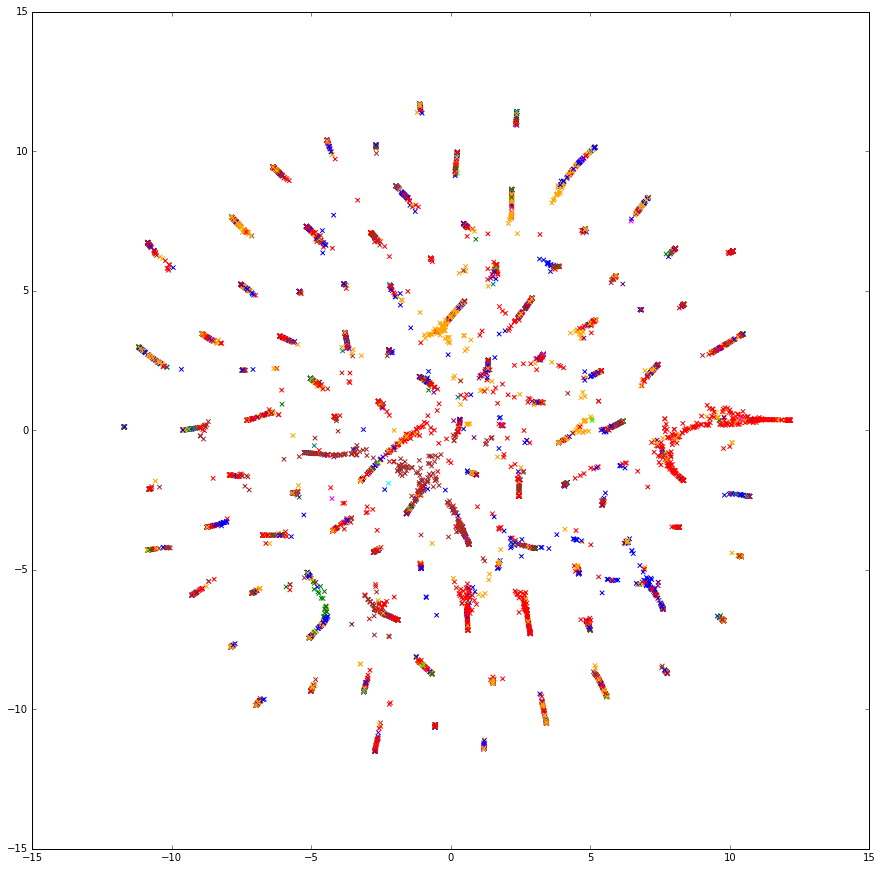

In [53]:
plt.scatter(df[0], df[1], c=labels, marker='x')